In [ ]:
!pip install diffusers
!pip install transformers
!pip install accelerate
!pip install pydub



  Using cached accelerate-0.26.1-py3-none-any.whl (270 kB)


In [ ]:
import torch
from diffusers import StableDiffusionPipeline

import numpy as np
from PIL import Image
import pydub
from scipy.io import wavfile
import torch
import torchaudio
import io
import typing as T
from pydub import AudioSegment
from IPython.display import Audio, display


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
model_id2 = "riffusion/riffusion-model-v1"
pipe2 = StableDiffusionPipeline.from_pretrained(model_id2, torch_dtype=torch.float16)
pipe2 = pipe2.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

safety_checker/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:232: FutureWarning: The configuration file of the unet has set the default `sample_size` to smaller than 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the following: 
- CompVis/stable-diffusion-v1-4 
- CompVis/stable-diffusion-v1-3 
- CompVis/stable-diffusion-v1-2 
- CompVis/stable-diffusion-v1-1 
- runwayml/stable-diffusion-v1-5 
- runwayml/stable-diffusion-inpainting 
 you should change 'sample_size' to 64 in the configuration fil

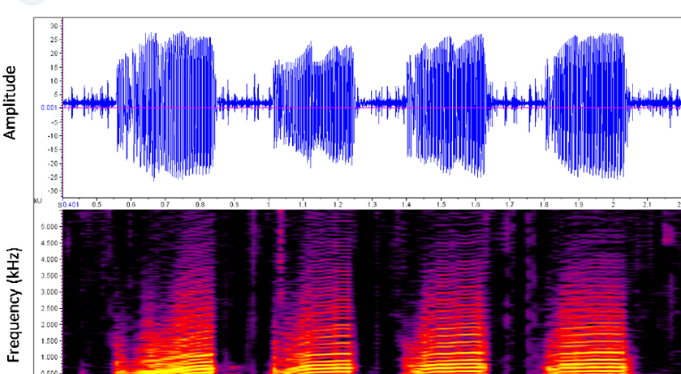

In [ ]:
#@title functions
def get_music(prompt, musicAI_indx, duration):
    mp3file_name = "audio3.mp3"
    wavfile_name = "audio3.wav"
    if musicAI_indx == 0:
        if duration == 5:
            width_duration=512
        else :
            width_duration = 512 + ((int(duration)-5) * 128)
        spec = pipe2(prompt, height=512, width=width_duration).images[0]
        print(spec)
        wav = wav_bytes_from_spectrogram_image(spec)
        with open(wavfile_name, "wb") as f:
            f.write(wav[0].getbuffer())


        #Convert to mp3, for video merging function
        wavfile = AudioSegment.from_wav(wavfile_name)
        wavfile.export(mp3file_name, format="mp3")
        return spec, mp3file_name
def wav_bytes_from_spectrogram_image(image: Image.Image) -> T.Tuple[io.BytesIO, float]:
    """
    Reconstruct a WAV audio clip from a spectrogram image. Also returns the duration in seconds.
    """

    max_volume = 50
    power_for_image = 0.25
    Sxx = spectrogram_from_image(image, max_volume=max_volume, power_for_image=power_for_image)

    sample_rate = 44100  # [Hz]
    clip_duration_ms = 5000  # [ms]

    bins_per_image = 512
    n_mels = 512

    # FFT parameters
    window_duration_ms = 100  # [ms]
    padded_duration_ms = 400  # [ms]
    step_size_ms = 10  # [ms]

    # Derived parameters
    num_samples = int(image.width / float(bins_per_image) * clip_duration_ms) * sample_rate
    n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
    hop_length = int(step_size_ms / 1000.0 * sample_rate)
    win_length = int(window_duration_ms / 1000.0 * sample_rate)

    samples = waveform_from_spectrogram(
        Sxx=Sxx,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        num_samples=num_samples,
        sample_rate=sample_rate,
        mel_scale=True,
        n_mels=n_mels,
        max_mel_iters=200,
        num_griffin_lim_iters=32,
    )

    wav_bytes = io.BytesIO()
    wavfile.write(wav_bytes, sample_rate, samples.astype(np.int16))
    wav_bytes.seek(0)

    duration_s = float(len(samples)) / sample_rate

    return wav_bytes, duration_s


def spectrogram_from_image(
    image: Image.Image, max_volume: float = 50, power_for_image: float = 0.25
) -> np.ndarray:
    """
    Compute a spectrogram magnitude array from a spectrogram image.
    TODO(hayk): Add image_from_spectrogram and call this out as the reverse.
    """
    # Convert to a numpy array of floats
    data = np.array(image).astype(np.float32)

    # Flip Y take a single channel
    data = data[::-1, :, 0]

    # Invert
    data = 255 - data

    # Rescale to max volume
    data = data * max_volume / 255

    # Reverse the power curve
    data = np.power(data, 1 / power_for_image)

    return data

def waveform_from_spectrogram(
    Sxx: np.ndarray,
    n_fft: int,
    hop_length: int,
    win_length: int,
    num_samples: int,
    sample_rate: int,
    mel_scale: bool = True,
    n_mels: int = 512,
    max_mel_iters: int = 200,
    num_griffin_lim_iters: int = 32,
    device: str = "cuda:0",
) -> np.ndarray:
    """
    Reconstruct a waveform from a spectrogram.
    This is an approximate inverse of spectrogram_from_waveform, using the Griffin-Lim algorithm
    to approximate the phase.
    """
    Sxx_torch = torch.from_numpy(Sxx).to(device)

    # TODO(hayk): Make this a class that caches the two things

    if mel_scale:
        mel_inv_scaler = torchaudio.transforms.InverseMelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
            #max_iter=max_mel_iters,
        ).to(device)

        Sxx_torch = mel_inv_scaler(Sxx_torch)

    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=1.0,
        n_iter=num_griffin_lim_iters,
    ).to(device)

    waveform = griffin_lim(Sxx_torch).cpu().numpy()

    return waveform


def mp3_bytes_from_wav_bytes(wav_bytes: io.BytesIO) -> io.BytesIO:
    mp3_bytes = io.BytesIO()
    sound = pydub.AudioSegment.from_wav(wav_bytes)
    sound.export(mp3_bytes, format="mp3")
    mp3_bytes.seek(0)
    return mp3_bytes

In [ ]:
get_music(prompt="jazz", musicAI_indx=0, duration=4)
display(Audio('audio.mp3', autoplay=True))

  0%|          | 0/50 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=384x512 at 0x7C6F2ACC9600>


In [ ]:
get_music(prompt="jazz", musicAI_indx=0, duration=10)
display(Audio('audio2.mp3', autoplay=True))

  0%|          | 0/50 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=1152x512 at 0x7C6F2AE58490>


In [ ]:
get_music(prompt="rock", musicAI_indx=0, duration=4)
display(Audio('audio3.mp3', autoplay=True))

  0%|          | 0/50 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=384x512 at 0x7C6F2AC954B0>
